# Rethinking the Simulated Environment
---

There are three components to the simulated environment.
1. production function
2. reward function
3. hydrology function

Marco and I mainly discussed the simulated environment and how to best model it.
After our meeting, I think it will be beneficial to significantly change the first and third components.
Changing two components leads to rethinking the reward function. Bellow we will examine the previous version of each
component and the proposed changes.

Lastly, Marco argued that the simulation should operate at the timescale of one year to integrate appropriately
with the new production function and to make the simulation more tractable within the scope of a master's thesis.

## 1. Production function
In the past iteration the production function was a biologically based function with water/day as input and growth/day
as output. Marco recommended changing the production function to an economically based production function.
This serves two purposes. It simplifies calibrating the production function to real world data and, as we will see in the
next section, it will integrate better with the reward function.

### Old production function:
$$ Q = K *log(x_{water})$$

$K = $ production constant for scaling

$x_{water} = $ amount of water applied to the crop

### New Production Function: Constant Elasticity of Substitution (CES)

CES is an aggregation production function with two or more production inputs that have some
elasticity of substitution.

$$ Q_i = \pi_i (\beta_{land} * x^\rho_{land} + \beta_{water} * x^\rho_{water})^{r/\rho} $$

$$ \beta_{land} + \beta_{water} = 1 $$

$ Q_i =$ quantity of output, pounds of crop $i$

$\pi_i = $ factor productivity, normalizes units, from real world data

$\beta = $ share parameter, measures how important each input is, from real world data

$\rho = $ substitution parameter, how willing is the agent to swap $x_{land}$ for $x_{water}$, from real world data

$r = $ returns to scale, does crop $ i $ have economies of scale, from real world data

$ x_{input} = $ quantity of given input, agents action space

### What will change

old state vector:

- available_water
- CropWater_n
- CropGrowth_n
- CropPrices_n

new state vector:

- available_water
- available_land
- one_hot_available_crops_vector
- crop price vector

Possible additions:
- Hidden state vector

old action vector:
- water for each crop

new action vector:
- water for each crop
- land for each crop

I would love to hear your feedback on the state vector. Does it make sense to have the previous land crop and reward?
This is reminiscent of an LSTM but is also somewhat similar to the occasional myopic view of farmers.

The production function Could also add additional inputs such as fertilizer ect.

## 2. Reward Function

Since this new production function returns weights for each crop, with a given price/weight we can calculate the reward
in dollars. Not so interesting. The more interesting result is that if dollars are our return scalar, then all other rewards
must be stated in dollars. For example, if we want to incorporate a return for leaving water in the river for the farmer
downstream farmer or for the ecological health of the river, we need to state that reward in dollars. To do this, Marco
recommended I use another economic concept called a shadow price. A shadow price aims to put a dollar value on the
externalities for a given action or good. I have not looked into what real world values for this look like, but it wil be the first step after
getting a minimum viable simulation.

## 3. Hydrology function

The main change to the hydrology function comes from the change in the time step for each episode. Since we switch to
a yearly interval for the production function, we need to change the hydrology model to switch to a yearly function that
still incorporate stochastic water supply.

Old hydrology function:

$$ W_t = A * sin(\omega t + \phi) $$

A standard oscillation formula.

New hydrology function:

$$ W_t \in P(W \vert L_{ocation}) $$

Now we sample from a distribution given some geographic location where the distribution is derived from real world data.


This will allow us to do nice things once the agents are trained such as skew or change the distribution
to simulate changing water availability due to climate change or some other factor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class SimConfig:
    """
    This config class simplifies the initialization of the SimulationCES class.
    """
    def __init__(self):

        self.num_crops = 2

        # TODO: use a dictionary to hold these values for different watersheds, then access watershed values via init argument
        # hydrology function, current estimate based on lower Clark Fork
        self.water_mu = 1.2e6       # cfs
        self.water_sigma = 1e3      # cfs
        self.aquifer_volume = self.water_mu * 2 # cf

        # stochastic water dist
        self.water_dist = self.water_sigma * np.random.randn(100) + self.water_mu
        # # constant water dist
        # self.water_dist = np.full(100, self.water_mu)

        # simulation parameters
        self.number_farmers = 3
        self.farmer_priority = [0, 1, 2]
        self.random_seed = 0

        # agent parameters
        # [available_water, available_land, crop_identity_vec, crop_price_vec]
        # FIXME: THIS WILL NEED TO CHANGE WHEN self.crop_list CHANGES TO ONE HOT VECTOR
        self.state_size = 2 + 2 * self.num_crops
        self.action_size = 2 * self.num_crops
        self.memory_size = 10

In [3]:
class Aquifer:
    # TODO: CURRENTLY THIS IS INCORPORATED IN THE SAME PRIORITY AS SURFACE WATER, CHANGING THIS MAY LEAD TO MORE INTERESTING DYNAMICS

    def __init__(self, initial_volume):
        self.available_volume = initial_volume
        self.recharge_mu = initial_volume * 0.1
        self.recharge_sigma = self.recharge_mu * 0.3

    def withdraw_water(self, amount):
        """
        Withdraws water from the aquifer.
        Currently allows for complete draining of the aquifer but prevents negative values.

        Amount in the aquifer is unknown to the farmer and therefore is not in the agent's state vector.
        :param amount: attempted water withdrawal
        :return: actual amount withdrawn
        """
        if amount < self.available_volume:
            self.available_volume -= amount

            return amount

        else:
            amount = self.available_volume
            self.available_volume = 0

            return amount

    def recharge_aquifer(self):
        """
        Stochastic recharge of the aquifer.
        Currently based in independent distribution but could be tied to surface water.
        :return: None
        """
        self.available_volume += np.random.randn() * self.recharge_sigma + self.recharge_mu

        return None

In [4]:
from CES_model.CES_Ag_agent import Agent

class SimulationCES:
    """
    Simulation environment utilizing CES production funtion
    """

    def __init__(self, config: SimConfig):
        # simulation configuration
        self.config = config

        # simulation records for analysis
        self.farmers_rewards_record = [[] for _ in range(config.number_farmers)]
        self.water_record = {"Aquifer": [],
                             "Surface": []}
        self.farmers_water_withdrawal_record = [[] for _ in range(config.number_farmers)]
        self.farmers_actions_record = [[] for _ in range(config.number_farmers)]

        # simulation parameters
        self.num_farmers = config.number_farmers
        self.farmer_priority = config.farmer_priority
        self.farmer_list = [Agent(config.state_size, config.action_size, config.random_seed, config.memory_size) for _ in range(self.num_farmers)]
        self.year = 1

        # simulation functions, reward function is a property
        self.hydrology_function = config.water_dist
        self.aquifer = Aquifer(config.aquifer_volume)

        # initialize river continuum
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        # land available to each farmer
        # FIXME: MAKE THIS COME FROM CONFIG FILE?
        self.available_land = [100 for _ in range(self.num_farmers)]



        # TODO: use a dictionary to hold these values for different watersheds, then access watershed values via init argument
        # production function parameters
        self.crop_1 = {"pi": 10,
                       "beta_land": 0.5,
                       "beta_water": 0.5,
                       "rho": 1,
                       "r": 1}
        self.crop_2 = {"pi": 10,
                       "beta_land": 0.3,
                       "beta_water": 0.7,
                       "rho": 1,
                       "r": 1}

        # TODO: use historic data to determine price distribution and sample from it each year to dynamically allocate price
        # TODO: DETERMINE IF ABOVE IS A REASONABLE ASSUMPTION GIVEN COMMODITY PRICE GUARANTEES.
        # TODO: ARRANGE THIS INFO INTO A VECTOR INHERENTLY, THIS WILL REQUIRE CHANGING THE REWARD FUNCTION CALC
        # reward function, has been turned into an @property
        # self.reward_function = self.reward_function()

        # TODO: THESE NEED TO GO INTO THE CONFIG CLASS
        self.crop_1_price = 10
        self.crop_2_price = 15
        self.crop_prices = [self.crop_1_price, self.crop_2_price]

        # cost parameters
        # TODO: IMPROVE FLEXIBILITY
        # NOT IN USE
        self.crop_list = np.array([1, 1])
        self.cost_mu = np.array([2, 3])
        self.cost_sigma = np.array([0.5, 0.5])
        # FIXME: FARMER HIDDEN STATE VECTOR, maybe


    def reset(self):
        """
        Resets the simulation environment. Open AI Gym interface.

        Only the river continuum needs to be reset each episode.
        Everything else needs to persist between episodes. I think...

        Returns: None
        """

        # recharge aquifer
        self.aquifer.recharge_aquifer()

        # re-initialize available water, this includes surface and aquifer
        self.source_water = self.init_available_water()
        self.available_water = [self.source_water for _ in range(self.num_farmers)]

        return None

    def reward_function(self, action):

        # FIXME: DEAL WITH THIS UNPACKING MORE ELEGANTLY
        x1_water, x2_water, x2_land,  x1_land  = action
        # FIXME: MAY INPUT A np.array FOR FLEXIBILITY
        """input amounts are the action space for the agents"""
        q_1 = self.crop_1["pi"] * (self.crop_1["beta_land"] * (x1_land ** self.crop_1["rho"]) + self.crop_1["beta_water"] * (x1_water ** self.crop_1["rho"])) ** (self.crop_1["r"] / self.crop_1["rho"])
        q_2 = self.crop_2["pi"] * (self.crop_2["beta_land"] * (x2_land ** self.crop_2["rho"]) + self.crop_2["beta_water"] * (x2_water ** self.crop_2["rho"])) ** (self.crop_2["r"] / self.crop_2["rho"])

        r_1 = np.log(q_1 * self.crop_1_price)
        r_2 = q_2 * self.crop_2_price

        land_cost = self.land_cost_function(x1_land + x2_land)
        water_cost = self.water_cost_function(x1_water + x2_water)
        total_cost = land_cost + water_cost

        # TODO: EXPAND THIS, it needs to be temporally correlated
        shadow_price = 0

        return r_1 + r_2 - total_cost - shadow_price

    def water_cost_function(self, total_water):
        """
        Non-Monotonic cost function for water.
        Currently assumes that each land use has equivalent costs.


        :param total_water:
        :return: total water cost
        """
        # TODO: ADJUST SO THAT THE COST FOR AQUIFER WITHDRAWALS IS DIFFERENT THAT SURFACE WATER
        w_0 = 3e-6

        cost = w_0 * total_water

        return cost

    def land_cost_function(self, total_land):
        """
        Non-Monotonic cost function for land.
        Currently assumes that each land use has equivalent costs.


        :param total_land: total land used by the farmer for both crops.
        :return: total land cost
        """
        w_0 = 1e-7

        cost = w_0 * total_land

        return cost

    def plot_reward(self, crop):

        # TODO: MAKE THIS FLEXIBLE TO PLOT DIFFERENT CROPS

        # crop 1
        x_len = int(2e6)
        # water crop 1
        water = np.arange(x_len) + 1
        # water crop 2
        water = np.stack((water, np.zeros(x_len)), axis=-1)

        # land crop 1, 100 total units available land for both crops
        land = np.full(x_len, 100)

        # land crop 2
        land = np.stack((land, np.zeros(x_len)), axis=-1)

        # combine water and land
        action_vec = np.concatenate((water, land), axis=-1)

        y = []
        for action in action_vec:
            y.append(test_env.reward_function(action))

        x = action_vec[:, 0]

        plt.title("Reward Function")
        plt.xlabel("Water")
        plt.ylabel("Reward")
        plt.plot(x, y)
        plt.show()

        return None

    def init_available_water(self):
        """
        Initializes available water for beginning of episode.
        Pulls random sample from historic discharge distribution.

        This needs to be a function call so that we get a new random number each time we want to initialize
        a seasons available water.

        Returns: (float) available water.
        """
        # get initial values for water types
        surface_water = np.random.choice(self.hydrology_function)
        aquifer = self.aquifer.available_volume

        # update water records
        self.water_record["Surface"].append(surface_water)
        self.water_record["Aquifer"].append(aquifer)

        return surface_water + aquifer

    def update_available_water(self, priority_index, action):
        """
        Updates all available water down stream from agent indicated by priority index.

        Args:
            priority_index: indicates at what point in the river continuum to update flows
            action: amount of water removed by agent
        """
        # determine the total water removed
        total_removed = np.sum(action[0:2])
        self.farmers_water_withdrawal_record[priority_index].append(total_removed)

        # remove water from aquifer
        aquifer_removed = self.aquifer.withdraw_water(total_removed / 2)

        # determine how much water needs to come from surface water
        surface_removed = total_removed - aquifer_removed

        # remove water from surface continuum, max operation prevents negative water amounts
        for i in range(priority_index, len(self.available_water)):

            self.available_water[i] = max(self.available_water[i] - surface_removed, 1e-3)

        return None

    def step(self):
        """
        Takes a step in the environment and updates all relevant instance attributes.

        This will look a little different than most other RL training loops for two reasons:
        1. This is inherently a multi agent system
        2. There is only one step in each episode

        Returns: None
        """

        # iterate through farmers in their priority order
        for priority_num in self.farmer_priority:
            agent = self.farmer_list[priority_num]
            state = np.concatenate((
                [self.available_water[priority_num]],
                [self.available_land[priority_num]],
                self.crop_list,
                self.crop_prices)
            )

            # get action, and record actions for debugging
            action = agent.act(state)
            self.farmers_actions_record[priority_num].append(action)

            reward = self.reward_function(action)
            self.update_available_water(priority_num, action)

            # save reward for later analysis
            self.farmers_rewards_record[priority_num].append(reward)

            # estimate next action and save state information in agent memory
            next_state = np.concatenate((
                [self.available_water[priority_num]],
                [self.available_land[priority_num]],
                self.crop_list,
                self.crop_prices)
            )
            # TODO: ADJUST AGENT ALG TO REMOVE done STATE FIELD
            agent.step(state, action, reward, next_state, False)

        # 1 year of simulation complete, reset the source water
        self.reset()
        self.year += 1

# # for debugging
# config = SimConfig()
# env = SimulationCES(config)
#
# num_years = 100
#
# for i_episode in range(1, num_years + 1):
#     env.step()

In [ ]:
config = SimConfig()
test_env = SimulationCES(config)

test_env.plot_reward(crop="crop 1")


In [ ]:
config = SimConfig()
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

In [ ]:
# red and green should be screwed

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

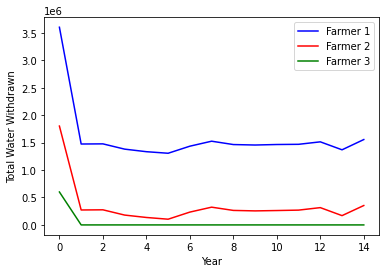

In [41]:
plt.xlabel("Year")
plt.ylabel("Total Water Withdrawn")
plt.plot(np.arange(env.year - 1), env.farmers_water_withdrawal_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_water_withdrawal_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_water_withdrawal_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()


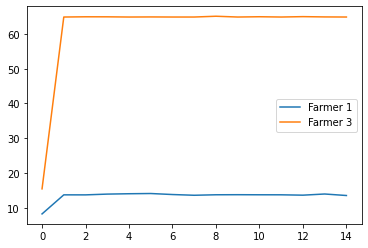

In [43]:
farmer_1, farmer_2, farmer_3 = env.farmers_actions_record
farmer_1_y = []
for action in farmer_1:
    farmer_1_y.append(env.reward_function(action))

farmer_3_y = []
for action in farmer_3:
    farmer_3_y.append(env.reward_function(action))

x = np.arange(15)
plt.plot(x, farmer_1_y, label="Farmer 1")
plt.plot(x, farmer_3_y, label="Farmer 3")
plt.legend()
plt.show()

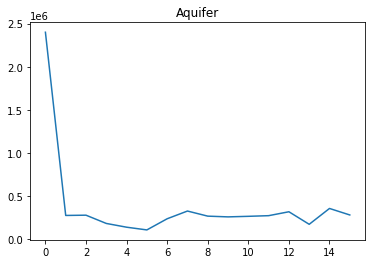

In [44]:
plt.title("Aquifer")
plt.plot(np.arange(env.year), env.water_record["Aquifer"])
plt.show()

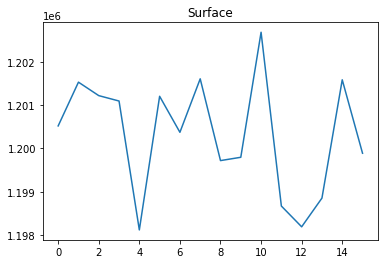

In [45]:
plt.title("Surface")
plt.plot(np.arange(env.year), env.water_record["Surface"])
plt.show()

The observed noise in the reward is due to the stochastic nature of the available water distribution.
In the config class you can switch between a constant water distribution, and a stochastic distribution to observe this.


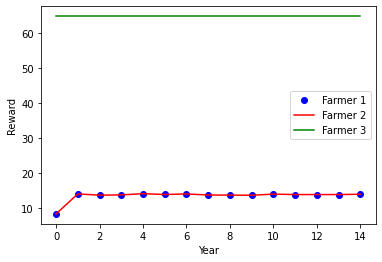

In [12]:
# green should be screwed

config = SimConfig()
config.farmer_priority = [1,0,2]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'bo', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

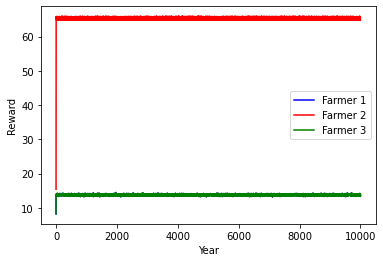

In [22]:
# red should be screwed

config = SimConfig()
config.farmer_priority = [2,0,1]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

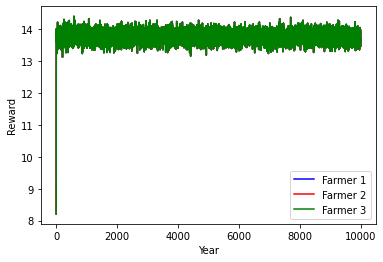

In [23]:
# no body should be screwed

config = SimConfig()
config.farmer_priority = [2,1,0]
env = SimulationCES(config)

num_years = 15

for i_episode in range(1, num_years + 1):
    env.step()

plt.xlabel("Year")
plt.ylabel("Reward")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[0], 'b-', label="Farmer 1")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[1], 'r-', label="Farmer 2")
plt.plot(np.arange(env.year - 1), env.farmers_rewards_record[2], 'g-', label="Farmer 3")
plt.legend()
plt.show()

The rewards should be reversed from what they are. There must be another bug somewhere in the simulation.

TODO:

1. simplify down to one farmer and one crop to make sure that the alg can find the max
1. add simulation members to debug the reversed trend observed in the behavior from plots
2. add in a regulatory agent
3. adjust aquifer recharge rate
4. incorporate the data from Marco's student, at least means first
